# Machine Learning Models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set working directory
import os
current_dir = os.getcwd()
os.chdir(current_dir.replace('\code', '\data'))

In [2]:
# Load data
data_ii = pd.read_csv('best_ball_mania_ii.csv')
data_iii = pd.read_csv('best_ball_mania_iii.csv')
data_iv = pd.read_csv('best_ball_mania_iv.csv')

In [3]:
# Increase 'roster_points' and 'pick_points' for dataset iv by 4.5
data_iv['pick_points'] = data_iv['pick_points']*4.5
data_iv['roster_points'] = data_iv['roster_points']*4.5

# Columns that are in all datasets
cols = list(set(data_ii.columns) & set(data_iii.columns) & set(data_iv.columns))

# Filter columns
data_ii = data_ii[cols]
data_iii = data_iii[cols]
data_iv = data_iv[cols]

# Concatenate data
data = pd.concat([data_ii, data_iii, data_iv], axis=0)

In [4]:
# Rename 'tournament_entry_id' to 'team_id'
data = data.rename(columns={'tournament_entry_id': 'team_id'})

data = data.drop(columns=['clock', 'tournament_round_number', 'bye_week', 'draft_time'])

# Fit a polynomial regression
p = np.poly1d(np.polyfit(data['overall_pick_number'], data['pick_points'], 2))
data['poly_points'] = p(data['overall_pick_number'])

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 648000 entries, 0 to 215999
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   pick_order           648000 non-null  int64  
 1   team_id              648000 non-null  object 
 2   position_name        648000 non-null  object 
 3   pick_points          648000 non-null  float64
 4   roster_points        648000 non-null  float64
 5   overall_pick_number  648000 non-null  int64  
 6   team_pick_number     648000 non-null  int64  
 7   draft_id             648000 non-null  object 
 8   projection_adp       648000 non-null  float64
 9   player_name          648000 non-null  object 
 10  playoff_team         648000 non-null  int64  
 11  poly_points          648000 non-null  float64
dtypes: float64(4), int64(4), object(4)
memory usage: 64.3+ MB


## Data Preprocessing for Models

make a df that has the selected ranking for each position. the team that selected the 7th WR has their first WR1 as "7."

make a df that has the average adp for each position. a team selects their WR1 and that individual had an adp of "2.3"

### Add a column in the cleaning notebook that identifies teams that happened to pick a player that scored an unexpected amount of points. Teams that picked the best player of that year should be flagged and teams that picked a top player that did absolutely nothing should also be flagged. This will be used to compare teams that are similar in terms of luck, two teams who happened to pick great players should be compared based on their position compositions

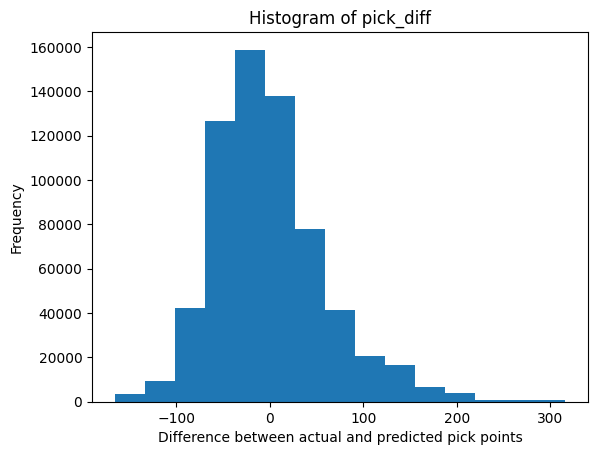

In [10]:
df = data.copy()

# New column, 'pick_diff', which is the difference between 'pick_points' and 'poly_points'
df['pick_diff'] = (df['pick_points'] - df['poly_points']).round(2)

# Histogram of 'pick_diff'
plt.hist(df['pick_diff'], bins=15)
plt.xlabel('Difference between actual and predicted pick points')
plt.ylabel('Frequency')
plt.title('Histogram of pick_diff')
plt.show()

In [22]:
def luck(data):
    df = data.copy()

    # New column, 'pick_diff', which is the difference between 'pick_points' and 'poly_points'
    df['pick_diff'] = (df['pick_points'] - df['poly_points']).round(2)

    # New column, 'pick_diff_max' which is the maximum 'pick_diff' for each 'team_id'
    df['pick_diff_max'] = df.groupby('team_id')['pick_diff'].transform('max')

    # New column, 'pick_diff_min' which is the minimum 'pick_diff' for each 'team_id'
    df['pick_diff_min'] = df.groupby('team_id')['pick_diff'].transform('min')

    # Percentiles of 'pick_diff'
    bottom = df['pick_diff'].quantile(0.025)
    top = df['pick_diff'].quantile(0.975)

    # New column, 'bad_luck' if pick_diff is in the bottom 15% of all pick_diff values
    df['bad_luck'] = np.where(df['pick_diff_min'] < bottom, 1, 0)

    # New column, 'good_luck' if pick_diff is in the top 15% of all pick_diff values
    df['good_luck'] = np.where(df['pick_diff_max'] > top, 1, 0)

    # Group data by 'team_id' and 'bad_luck' and 'good_luck'
    luck = df.groupby(['team_id', 'pick_diff_min', 'pick_diff_max', 'bad_luck', 'good_luck']).agg({'roster_points': 'mean'}).reset_index()

    return luck

luck(data).head()

,team_id,pick_diff_min,pick_diff_max,bad_luck,good_luck,roster_points
0,00022606-02af-42a0-90a8-70cace432a23,-40.29,104.10,0,0,1622.50
1,0004f1ae-d936-4b68-9750-048a0cca39af,-81.85,125.03,0,0,1177.38
2,00052309-90cc-45d0-9152-0a9ab5446d47,-79.29,98.24,0,0,1487.10
3,0006d0e4-ecbc-4459-9db6-ab6b3ff3ce69,-76.29,184.55,0,1,1633.24
4,0009a8de-3e8e-44cd-a632-e332a407f440,-80.46,190.57,0,1,1752.82


In [26]:
# Average 'roster_points' for 'bad_luck' and 'good_luck' combinations
df = luck(data).groupby(['bad_luck', 'good_luck']).agg({'roster_points': 'mean'}).reset_index()

# Add value counts for 'bad_luck' and 'good_luck' combinations
df['count'] = luck(data).groupby(['bad_luck', 'good_luck']).size().values

df

,bad_luck,good_luck,roster_points,count
0,0,0,1518.256626,14829
1,0,1,1601.740374,7611
2,1,0,1449.655595,7702
3,1,1,1557.057786,5858


In [27]:
# Transform data into the selection at which each team drafted each position
def ordinal_ranks(data, drop_columns=False, empty_value=1000):
    # Group by 'draft_id', 'position_name', 'pick_points' and 'overall_pick_number'
    df = data[['team_id', 'position_name', 'overall_pick_number', 'pick_points']]
    roster_points = data[['team_id', 'roster_points']].drop_duplicates()

    data_grouped = df.groupby(['team_id', 'position_name', 'overall_pick_number']).mean().reset_index()
    data_grouped = data_grouped[['team_id', 'position_name', 'overall_pick_number']]
    data_grouped = data_grouped.drop(data_grouped[data_grouped['position_name'] == 'FB'].index)

    # New column 'pos_rank' which is the rank of the 'position_name' in each 'draft_id'
    # if lowest 'overall_pick_number' then rank is 1, if second lowest then rank is 2, and so on
    data_grouped['pos_rank'] = data_grouped.groupby(['team_id', 'position_name'])['overall_pick_number'].rank()

    # New column pos_team_rank which is position_name + pos_rank
    data_grouped['pos_team_rank'] = data_grouped['position_name'] + data_grouped['pos_rank'].astype(str)

    # Pivot the data so that position names are columns, and overall pick numbers are rows
    data_grouped = data_grouped.pivot(index='team_id', columns='pos_team_rank', values='overall_pick_number').reset_index()

    # Drop columns below 5 percent full
    if drop_columns == True:
        data_grouped = data_grouped.dropna(thresh=0.30*len(data_grouped), axis=1)

    # Fill NaN values with empty_value
    data_grouped = data_grouped.fillna(empty_value)

    # Merge with 'roster_points'
    data_grouped = data_grouped.merge(roster_points, on='team_id')
    
    # Drop 'team_id' column
    data_grouped = data_grouped.drop(columns=['team_id'])

    return data_grouped

ordinal_ranks(data, drop_columns=False).head()

,QB1.0,QB2.0,QB3.0,QB4.0,QB5.0,QB6.0,QB7.0,QB8.0,RB1.0,RB10.0,...,WR12.0,WR2.0,WR3.0,WR4.0,WR5.0,WR6.0,WR7.0,WR8.0,WR9.0,roster_points
0,36.0,156.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,13.0,1000.0,...,1000.0,60.0,61.0,84.0,85.0,133.0,181.0,204.0,1000.0,1622.50
1,47.0,194.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,26.0,1000.0,...,1000.0,23.0,50.0,119.0,122.0,143.0,167.0,191.0,215.0,1177.38
2,68.0,188.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,5.0,1000.0,...,1000.0,44.0,53.0,77.0,92.0,116.0,164.0,173.0,212.0,1487.10
3,115.0,126.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,6.0,1000.0,...,1000.0,30.0,67.0,78.0,91.0,102.0,163.0,187.0,211.0,1633.24
4,31.0,151.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,7.0,1000.0,...,1000.0,66.0,79.0,103.0,127.0,186.0,210.0,1000.0,1000.0,1752.82


In [28]:
# Transform data into the "value" of the selection at which each team drafted each position
def value_ranks(data, drop_columns):
    # Introduce data: the selection at which each position was drafted
    empty_value = 1000
    df = ordinal_ranks(data, drop_columns, empty_value)

    # Fit a polynomial regression
    p = np.poly1d(np.polyfit(data['overall_pick_number'], data['pick_points'], 2))

    # Use the polynomial regression to find the value of each selection, except for column: 'roster_points'
    roster_points = df['roster_points']
    df = df.drop(columns=['roster_points'])
    df = df.map(lambda x: p(x))

    # Replace all null values with 0
    df = df.replace(p(empty_value), 0)
    df = df.round(2)
    
    # Add roster_points back to the dataframe
    df['roster_points'] = roster_points

    return df

value_ranks(data, drop_columns=True).head()

,QB1.0,QB2.0,QB3.0,RB1.0,RB2.0,RB3.0,RB4.0,RB5.0,RB6.0,TE1.0,...,TE3.0,WR1.0,WR2.0,WR3.0,WR4.0,WR5.0,WR6.0,WR7.0,WR8.0,roster_points
0,130.66,51.84,0.0,153.16,75.59,74.99,51.46,43.85,38.29,129.73,...,0.0,154.20,109.71,108.89,91.36,90.65,61.93,43.58,38.46,1622.50
1,120.74,40.39,0.0,140.15,98.69,83.81,81.85,55.94,0.00,100.98,...,0.0,164.77,143.09,118.12,69.23,67.59,57.25,47.86,41.06,1177.38
2,103.31,41.77,0.0,161.55,146.06,66.00,58.61,54.66,0.00,79.92,...,0.0,137.26,123.39,115.55,96.44,85.81,70.91,48.89,45.92,1487.10
3,71.48,65.47,0.0,160.49,124.28,59.07,54.24,39.56,0.00,114.70,...,0.0,147.06,136.30,104.09,95.70,86.49,79.29,49.24,42.01,1633.24
4,135.35,53.83,0.0,159.43,113.86,87.17,72.06,59.53,45.30,148.07,...,0.0,125.18,104.88,94.97,78.66,64.95,42.26,37.51,0.00,1752.82


In [29]:
def luck_ranks(data, drop_columns, empty_value=1000):
    # Utilize luck function
    luck_df = luck(data)

    # Group by 'draft_id', 'position_name', 'pick_points' and 'overall_pick_number'
    df = data[['team_id', 'position_name', 'overall_pick_number', 'pick_points']]
    roster_points = data[['team_id', 'roster_points']].drop_duplicates()

    data_grouped = df.groupby(['team_id', 'position_name', 'overall_pick_number']).mean().reset_index()
    data_grouped = data_grouped[['team_id', 'position_name', 'overall_pick_number']]
    data_grouped = data_grouped.drop(data_grouped[data_grouped['position_name'] == 'FB'].index)

    # New column 'pos_rank' which is the rank of the 'position_name' in each 'draft_id'
    # if lowest 'overall_pick_number' then rank is 1, if second lowest then rank is 2, and so on
    data_grouped['pos_rank'] = data_grouped.groupby(['team_id', 'position_name'])['overall_pick_number'].rank()

    # New column pos_team_rank which is position_name + pos_rank
    data_grouped['pos_team_rank'] = data_grouped['position_name'] + data_grouped['pos_rank'].astype(str)

    # Pivot the data so that position names are columns, and overall pick numbers are rows
    data_grouped = data_grouped.pivot(index='team_id', columns='pos_team_rank', values='overall_pick_number').reset_index()

    # Drop columns below 5 percent full
    if drop_columns == True:
        data_grouped = data_grouped.dropna(thresh=0.30*len(data_grouped), axis=1)

    # Fill NaN values with empty_value
    data_grouped = data_grouped.fillna(empty_value)

    # Merge with 'roster_points'
    data_grouped = data_grouped.merge(roster_points, on='team_id')

    # Merge dataframes
    data_grouped = data_grouped.merge(luck_df[['team_id', 'bad_luck', 'good_luck']], on='team_id')

    # Drop 'team_id' column
    data_grouped = data_grouped.drop(columns=['team_id'])

    return data_grouped

luck_ranks(data, drop_columns=False).head()

,QB1.0,QB2.0,QB3.0,QB4.0,QB5.0,QB6.0,QB7.0,QB8.0,RB1.0,RB10.0,...,WR3.0,WR4.0,WR5.0,WR6.0,WR7.0,WR8.0,WR9.0,roster_points,bad_luck,good_luck
0,36.0,156.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,13.0,1000.0,...,61.0,84.0,85.0,133.0,181.0,204.0,1000.0,1622.50,0,0
1,47.0,194.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,26.0,1000.0,...,50.0,119.0,122.0,143.0,167.0,191.0,215.0,1177.38,0,0
2,68.0,188.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,5.0,1000.0,...,53.0,77.0,92.0,116.0,164.0,173.0,212.0,1487.10,0,0
3,115.0,126.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,6.0,1000.0,...,67.0,78.0,91.0,102.0,163.0,187.0,211.0,1633.24,0,1
4,31.0,151.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,7.0,1000.0,...,79.0,103.0,127.0,186.0,210.0,1000.0,1000.0,1752.82,0,1


## Feature Engineering

In [40]:
# Get data
df = luck_ranks(data, drop_columns=False)

# Add position counts
df['qb_count'] = df.filter(like='QB').gt(0).sum(axis=1)
df['rb_count'] = df.filter(like='RB').gt(0).sum(axis=1)
df['wr_count'] = df.filter(like='WR').gt(0).sum(axis=1)
df['te_count'] = df.filter(like='TE').gt(0).sum(axis=1)

# Add position value allocation
df['qb_value'] = df.filter(like='QB').sum(axis=1)
df['rb_value'] = df.filter(like='RB').sum(axis=1)
df['wr_value'] = df.filter(like='WR').sum(axis=1)
df['te_value'] = df.filter(like='TE').sum(axis=1)

# Add position variance in value
df['qb_var'] = df.filter(like='QB').var(axis=1).round(2)
df['rb_var'] = df.filter(like='RB').var(axis=1).round(2)
df['wr_var'] = df.filter(like='WR').var(axis=1).round(2)
df['te_var'] = df.filter(like='TE').var(axis=1).round(2)

# Add high draft pick count
df['qb_early'] = df.filter(like='QB').gt(120).sum(axis=1)
df['rb_early'] = df.filter(like='RB').gt(120).sum(axis=1)
df['wr_early'] = df.filter(like='WR').gt(120).sum(axis=1)
df['te_early'] = df.filter(like='TE').gt(120).sum(axis=1)

# Add top vs. bottom value difference 
df['qb_diff'] = df.filter(like='QB').max(axis=1) - df.filter(like='QB').min(axis=1)
df['rb_diff'] = df.filter(like='RB').max(axis=1) - df.filter(like='RB').min(axis=1)
df['wr_diff'] = df.filter(like='WR').max(axis=1) - df.filter(like='WR').min(axis=1)
df['te_diff'] = df.filter(like='TE').max(axis=1) - df.filter(like='TE').min(axis=1)

# Add interaction terms
df['qb_rb'] = (df['qb_value'] * df['rb_value']).round(0)
df['qb_wr'] = (df['qb_value'] * df['wr_value']).round(0)
df['qb_te'] = (df['qb_value'] * df['te_value']).round(0)
df['rb_wr'] = (df['rb_value'] * df['wr_value']).round(0)
df['rb_te'] = (df['rb_value'] * df['te_value']).round(0)
df['wr_te'] = (df['wr_value'] * df['te_value']).round(0)

# Keep columns
columns_to_keep = ['QB1.0', 'QB2.0', 'RB1.0', 'RB2.0', 'RB3.0', 'RB4.0', 'TE1.0', 'TE2.0',
       'WR1.0', 'WR2.0', 'WR3.0', 'WR4.0', 'WR5.0', 'WR6.0', 'roster_points',
       'qb_count', 'rb_count', 'wr_count', 'te_count', 'qb_value', 'rb_value',
       'wr_value', 'te_value', 'qb_var', 'rb_var', 'wr_var', 'te_var',
       'qb_early', 'rb_early', 'wr_early', 'te_early', 'qb_diff', 'rb_diff',
       'wr_diff', 'te_diff', 'qb_rb', 'qb_wr', 'qb_te', 'rb_wr', 'rb_te',
       'wr_te', 'bad_luck', 'good_luck']
df = df[columns_to_keep]

df.head()

,QB1.0,QB2.0,RB1.0,RB2.0,RB3.0,RB4.0,TE1.0,TE2.0,WR1.0,WR2.0,...,wr_diff,te_diff,qb_rb,qb_wr,qb_te,rb_wr,rb_te,wr_te,bad_luck,good_luck
0,36.0,156.0,13.0,108.0,109.0,157.0,37.0,132.0,12.0,60.0,...,988.0,963.0,29548224.0,29845440.0,25814448.0,23001040.0,19894468.0,20094580.0,0,0
1,47.0,194.0,26.0,74.0,95.0,98.0,71.0,170.0,2.0,23.0,...,998.0,929.0,33944799.0,25163712.0,26468081.0,21930048.0,23066799.0,17099712.0,0,0
2,68.0,188.0,5.0,20.0,125.0,140.0,101.0,197.0,29.0,44.0,...,971.0,899.0,34026384.0,24773760.0,26888288.0,21538440.0,23376822.0,17020080.0,0,0
3,115.0,126.0,6.0,43.0,139.0,150.0,54.0,174.0,19.0,30.0,...,981.0,946.0,34550176.0,24639468.0,26386948.0,21856128.0,23406208.0,16692144.0,0,1
4,31.0,151.0,7.0,55.0,90.0,114.0,18.0,162.0,42.0,66.0,...,958.0,982.0,23355596.0,35935966.0,25840760.0,21961514.0,15792040.0,24298340.0,0,1


In [105]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Load data
X = ['QB1.0', 'QB2.0', 'RB1.0', 'RB2.0', 'RB3.0', 'RB4.0', 'TE1.0', 'TE2.0',
       'WR1.0', 'WR2.0', 'WR3.0', 'WR4.0', 'WR5.0', 'WR6.0', #'roster_points',
       'qb_count', 'rb_count', 'wr_count', 'te_count', 'qb_value', 'rb_value',
       'wr_value', 'te_value', 'qb_var', 'rb_var', 'wr_var', 'te_var',
       'qb_early', 'rb_early', 'wr_early', 'te_early', 'qb_diff', 'rb_diff',
       'wr_diff', 'te_diff', 'qb_rb', 'qb_wr', 'qb_te', 'rb_wr', 'rb_te',
       'wr_te']
y = df['roster_points']

# Define the model
dbscan = DBSCAN(eps=50000, min_samples=500)
dbscan.fit(X)
labels_dbscan = dbscan.labels_
score = silhouette_score(X, labels_dbscan)

# Summarize clusters in the data
df['dbscan'] = labels_dbscan

print(f"Silhouette score: {score:.2f}")
print(f"Number of clusters: {len(df['dbscan'].unique())}")
print(f"StDev of roster points by cluster: {df.groupby('dbscan').mean()['roster_points'].std()}")

Silhouette score: 0.60
Number of clusters: 2
StDev of roster points by cluster: 63.463178633572326


In [106]:
# Kmeans clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X = ['QB1.0', 'QB2.0', 'RB1.0', 'RB2.0', 'RB3.0', 'RB4.0', 'TE1.0', 'TE2.0',
       'WR1.0', 'WR2.0', 'WR3.0', 'WR4.0', 'WR5.0', 'WR6.0', #'roster_points',
       'qb_count', 'rb_count', 'wr_count', 'te_count', 'qb_value', 'rb_value',
       'wr_value', 'te_value', 'qb_var', 'rb_var', 'wr_var', 'te_var',
       'qb_early', 'rb_early', 'wr_early', 'te_early', 'qb_diff', 'rb_diff',
       'wr_diff', 'te_diff', 'qb_rb', 'qb_wr', 'qb_te', 'rb_wr', 'rb_te',
       'wr_te']
y = df['roster_points']

# Define the model
kmeans = KMeans(n_clusters=12)
kmeans.fit(X)
labels_kmeans = kmeans.labels_
score = silhouette_score(X, labels_kmeans)

# Summarize clusters in the data
df['kmeans'] = labels_kmeans

print(f"Silhouette score: {score:.2f}")
print(f"Number of clusters: {len(df['kmeans'].unique())}")
print(f"StDev of roster points by cluster: {df.groupby('kmeans').mean()['roster_points'].std()}")

Silhouette score: 0.21
Number of clusters: 12
StDev of roster points by cluster: 12.711424195993878


In [110]:
# Hierarchical clustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

X = ['QB1.0', 'QB2.0', 'RB1.0', 'RB2.0', 'RB3.0', 'RB4.0', 'TE1.0', 'TE2.0',
       'WR1.0', 'WR2.0', 'WR3.0', 'WR4.0', 'WR5.0', 'WR6.0', #'roster_points',
       'qb_count', 'rb_count', 'wr_count', 'te_count', 'qb_value', 'rb_value',
       'wr_value', 'te_value', 'qb_var', 'rb_var', 'wr_var', 'te_var',
       'qb_early', 'rb_early', 'wr_early', 'te_early', 'qb_diff', 'rb_diff',
       'wr_diff', 'te_diff', 'qb_rb', 'qb_wr', 'qb_te', 'rb_wr', 'rb_te',
       'wr_te']
y = df['roster_points']

# Define the model
agg = AgglomerativeClustering(n_clusters=12)
agg.fit(X)
labels_agg = agg.labels_
score = silhouette_score(X, labels_agg)

# Summarize clusters in the data
df['agg'] = labels_agg

print(f"Silhouette score: {score:.2f}")
print(f"Number of clusters: {len(df['agg'].unique())}")
print(f"StDev of roster points by cluster: {df.groupby('agg').mean()['roster_points'].std()}")

Silhouette score: 0.12
Number of clusters: 12
StDev of roster points by cluster: 13.957417200503214


## Modeling

In [41]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold

# Load data
#df = luck_ranks(data, drop_columns=False, empty_value=1000)
df = df[(df['bad_luck'] == 0) & (df['good_luck'] == 0)]
X = df.drop(columns=['roster_points', 'good_luck', 'bad_luck'])
y = df['roster_points']

# Fit an XGBoost regressor
xgbr = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.75, max_depth=7, subsample=0.90)

# Implement k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True)
scores = cross_val_score(xgbr, X, y, cv=kfold)

# Print the mean and standard deviation of the scores
print(f"Cross-validation R^2 score: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")

Cross-validation R^2 score: -0.03 (+/- 0.02)


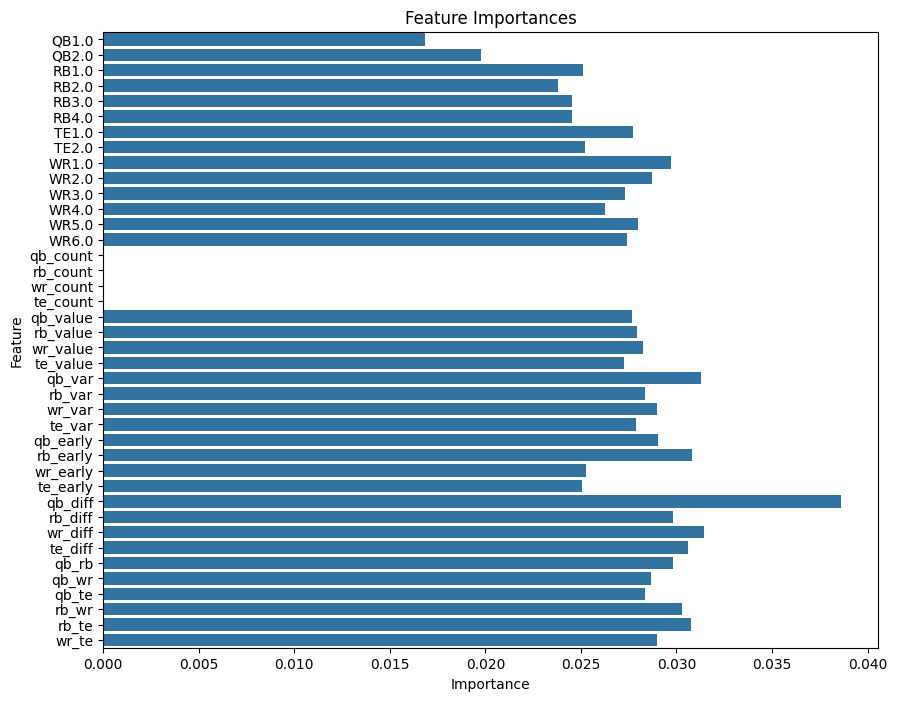

In [37]:
# Feature importance
xgbr.fit(X, y)

# Get feature importances
importances = xgbr.feature_importances_

plt.figure(figsize=(10, 8))
sns.barplot(x=importances, y=X.columns)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [45]:
from sklearn.preprocessing import StandardScaler

# Use dnn to predict the roster_points of the data
def predict_roster_points(X, y, model):

    # Split the data into X and y
    X = df.drop(columns='roster_points')
    y = df['roster_points']

    # Scale the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Predict the roster_points
    df['predicted_roster_points'] = model.predict(X)

    return df

ADF Statistic: -53.97786898657713
p-value: 0.0


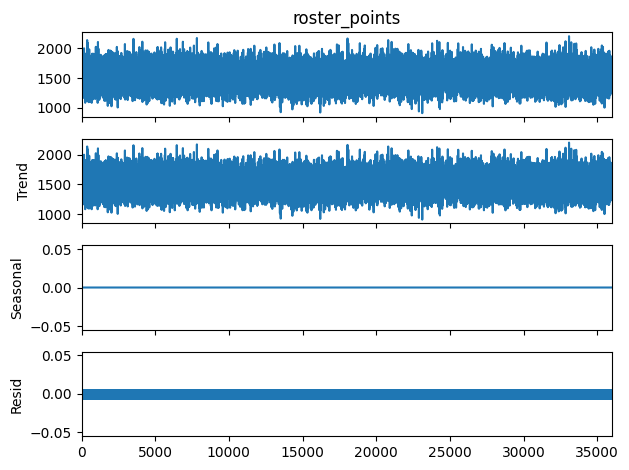

In [118]:
# Time Series Analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load data
data = df['roster_points']

# Check for stationarity
result = adfuller(data)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Decompose the time series
decomposition = seasonal_decompose(data, period=1)
decomposition.plot()
plt.show()

In [92]:
# DNN Model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import BatchNormalization
from keras.regularizers import l2

# Split the data into X and y
X = df.drop(columns='roster_points')
y = df['roster_points']

def dnn_model(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    # Scale the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # Create the model
    model = Sequential()
    model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(2000, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(500, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(optimizer=Adam(0.001, decay=1e-6), loss='mean_squared_error')
    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    # Fit the model
    model.fit(x=X_train, y=y_train.values, validation_data=(X_test, y_test.values), batch_size=30, epochs=1000, callbacks=[early_stop])
    return model

dnn = dnn_model(X, y)

Epoch 1/1000


c:\Users\Jack\Documents\GitHub\FFInsights\code\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Jack\Documents\GitHub\FFInsights\code\.conda\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


960/960 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 2101306.7500 - val_loss: 483474.6875
Epoch 2/1000
960/960 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 234446.0000 - val_loss: 22311.2598
Epoch 3/1000
960/960 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 25663.5781 - val_loss: 22389.8926
Epoch 4/1000
960/960 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - loss: 25210.8691 - val_loss: 22067.7949
Epoch 5/1000
960/960 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - loss: 25312.9395 - val_loss: 22076.0391
Epoch 6/1000
960/960 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - loss: 24935.0254 - val_loss: 21978.3164
Epoch 7/1000
960/960 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - loss: 25050.3340 - val_loss: 21990.4824
Epoch 8/1000
960/960 ━━━━━━━━━━━━━━━━━━━━ 34s 35ms/step - loss: 24608.4590 - val_loss: 22001.0859
Epoch 9/1000
960/960 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - loss: 24961.4844 - val_loss: 21962.8027
Epoch 10/1000
960/960 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - loss: 25008.9492 - val_loss: 22019.9648
Epoch 11/1000
960/960 ━━━━━━

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


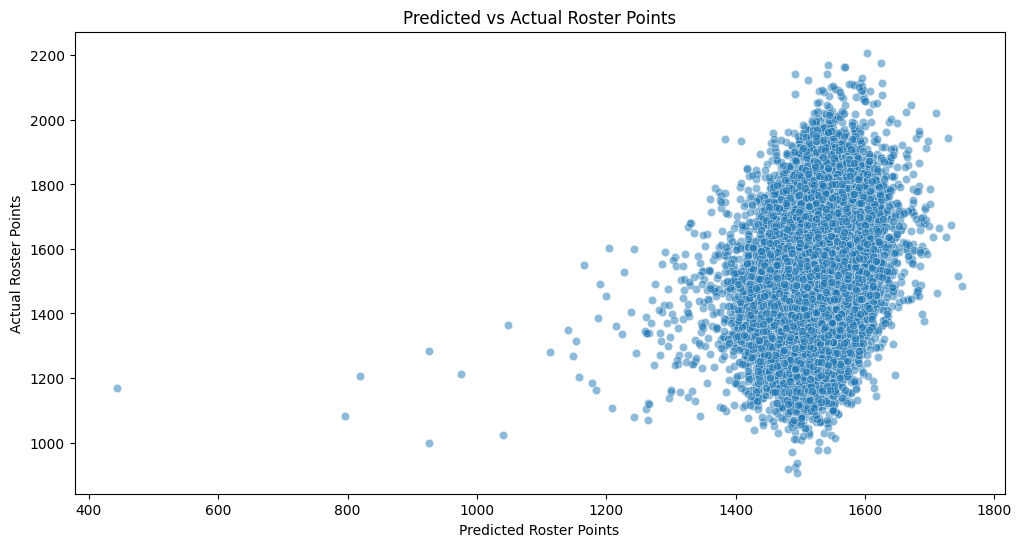

In [93]:
dnn_predictions = predict_roster_points(X, y, dnn)

# Plot the predicted roster_points against the actual roster_points
plt.figure(figsize=(12, 6))
sns.scatterplot(x='predicted_roster_points', y='roster_points', data=dnn_predictions, alpha=0.50)
plt.xlabel('Predicted Roster Points')
plt.ylabel('Actual Roster Points')
plt.title('Predicted vs Actual Roster Points')
plt.show()

In [96]:
# CNN Model
from keras.layers import Conv1D, MaxPooling1D, Flatten

# Split the data into X and y
X = df.drop(columns='roster_points')
y = df['roster_points']

def cnn_model(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    # Scale the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # Reshape the data
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    # Create the model
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(250, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(optimizer=Adam(0.001), loss='mean_squared_error')
    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    # Fit the model
    model.fit(x=X_train, y=y_train.values, validation_data=(X_test, y_test.values), batch_size=30, epochs=1000, callbacks=[early_stop])
    return model

cnn = cnn_model(X, y)

Epoch 1/1000


c:\Users\Jack\Documents\GitHub\FFInsights\code\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


960/960 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 221143.4375 - val_loss: 25303.6875
Epoch 2/1000
960/960 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 31225.1719 - val_loss: 25009.1230
Epoch 3/1000
960/960 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 30709.2520 - val_loss: 23454.6465
Epoch 4/1000
960/960 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 30448.2656 - val_loss: 22539.5840
Epoch 5/1000
960/960 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - loss: 30145.3008 - val_loss: 32107.4180
Epoch 6/1000
960/960 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - loss: 29659.1543 - val_loss: 22770.4785
Epoch 7/1000
960/960 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 28861.8730 - val_loss: 23942.0918
Epoch 8/1000
960/960 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 29738.2734 - val_loss: 31385.2285
Epoch 9/1000
960/960 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 28960.4160 - val_loss: 22658.7324
Epoch 10/1000
960/960 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - loss: 28803.2559 - val_loss: 24654.5977
Epoch 11/1000
960/960 ━━━━━━━━━

KeyboardInterrupt: 

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


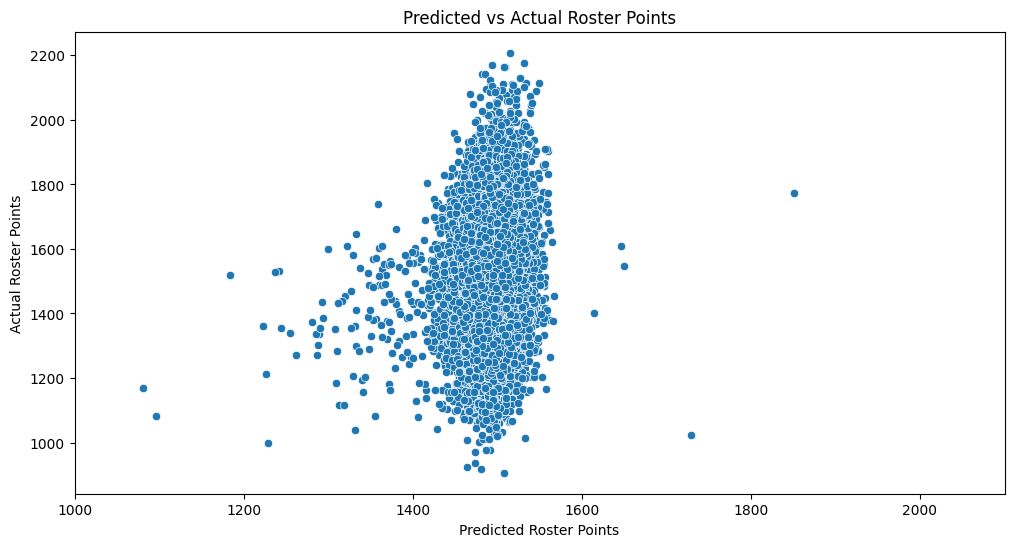

In [58]:
cnn_predictions = predict_roster_points(X, y, cnn)

# Plot the predicted roster_points against the actual roster_points
plt.figure(figsize=(12, 6))
sns.scatterplot(x='predicted_roster_points', y='roster_points', data=cnn_predictions, alpha=0.50)
plt.xlim(1000, 2100)
plt.xlabel('Predicted Roster Points')
plt.ylabel('Actual Roster Points')
plt.title('Predicted vs Actual Roster Points')
plt.show()

In [94]:
# GNN Model
import tensorflow as tf
from tensorflow.keras import layers
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data into X and y
X = df.drop(columns='roster_points')
y = df['roster_points']

def gnn_model(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    # Scale the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # Reshape the data
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    # Create the model
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1], 1)))
    model.add(layers.Conv1D(filters=32, kernel_size=2, activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(500, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(250, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    # Fit the model
    model.fit(x=X_train, y=y_train.values, validation_data=(X_test, y_test.values), batch_size=30, epochs=1000, callbacks=[early_stop])
    return model

gnn = gnn_model(X, y)

Epoch 1/1000
960/960 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 331565.3750 - val_loss: 25011.3418
Epoch 2/1000
960/960 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 38284.5469 - val_loss: 22416.5332
Epoch 3/1000
960/960 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 36453.4297 - val_loss: 22319.5938
Epoch 4/1000
960/960 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 36159.7422 - val_loss: 30026.2871
Epoch 5/1000
960/960 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 34129.3516 - val_loss: 21906.3086
Epoch 6/1000
960/960 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 33443.6719 - val_loss: 29751.3398
Epoch 7/1000
960/960 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 32732.7266 - val_loss: 36188.8438
Epoch 8/1000
960/960 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 31764.9688 - val_loss: 24708.9043
Epoch 9/1000
960/960 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 30014.2129 - val_loss: 45997.3828
Epoch 10/1000
960/960 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 28876.5000 - val_loss: 59653.1562
Epoch 10: early stopping


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


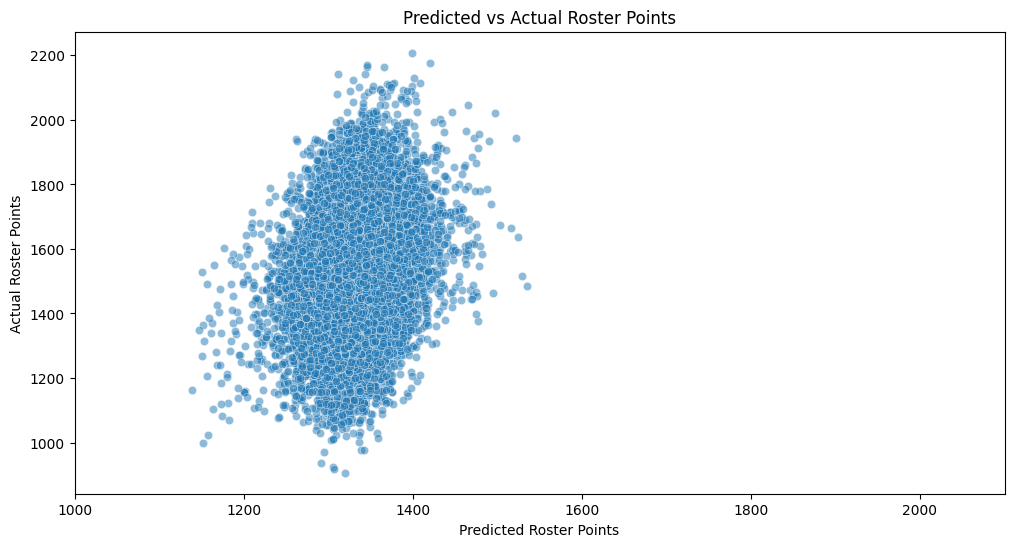

In [95]:
gnn_predictions = predict_roster_points(X, y, gnn)

# Plot the predicted roster_points against the actual roster_points
plt.figure(figsize=(12, 6))
sns.scatterplot(x='predicted_roster_points', y='roster_points', data=gnn_predictions, alpha=0.50)
plt.xlim(1000, 2100)
plt.xlabel('Predicted Roster Points')
plt.ylabel('Actual Roster Points')
plt.title('Predicted vs Actual Roster Points')
plt.show()

In [42]:
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, KFold

X = df.drop(columns='roster_points')
y = df['roster_points']

# Define the base models
xgb1 = XGBRegressor(n_estimators=1000, learning_rate=0.01, colsample_bytree=0.75, max_depth=6, subsample=0.67)
xgb2 = XGBRegressor(n_estimators=150, learning_rate=0.1, max_depth=10)

# Define the final estimator
final_estimator = XGBRegressor(n_estimators=25, learning_rate=0.1)

# Define the ensemble model
model = StackingRegressor(estimators=[('xgb1', xgb1), ('xgb2', xgb2)], final_estimator=final_estimator)

# Implement k-fold cross-validation
kfold = KFold(n_splits=2)
scores = cross_val_score(model, X, y, cv=kfold)

# Print the mean and standard deviation of the scores
print(f"Cross-validation R^2 score: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")

Cross-validation R^2 score: 0.04 (+/- 0.00)
